In [1]:
import gym
import numpy as np

from tqdm import trange

env = gym.make('Pendulum-v0')

The pendulum challenge is to keep a 
frictionless pendulum standing up

# The Pendulum

## States

| Num | Observation |
|:-:|:-:|
| 0 | cos(theta) |
| 1 | sin(theta) |
| 2 | theta dot |


<style>
td {
  font-size: 100px
}
    
    
</style>


In [2]:
print(f"The shape of the state space: {env.observation_space.shape}")
print(f"Highest value: {env.observation_space.high}")
print(f"Lowest value: {env.observation_space.low}")

env.observation_space

print(f"A sample state: {env.observation_space.sample()}")

The shape of the state space: (3,)
Highest value: [1. 1. 8.]
Lowest value: [-1. -1. -8.]
A sample state: [-0.32992855  0.3910986  -0.79932666]


## Actions

| Num | Action |
|:-:|:-:|
| 0 | Joint effort |

In [3]:
print(f"The shape of the action space: {env.action_space.shape}")
print(f"Highest value: {env.action_space.high}")
print(f"Lowest value: {env.action_space.low}")

env.action_space.seed(473)

print(f"A sample action: {env.action_space.sample()}")

The shape of the action space: (1,)
Highest value: [2.]
Lowest value: [-2.]
A sample action: [-0.8608973]


In [4]:
env.action_space.sample()

array([1.8785995], dtype=float32)

## Reward

Function: $-(theta^2 + 0.1*thetaDot^2 + 0.001*action^2)$

# The Agent

In [5]:
import sys
import numpy as np
import pandas as pd
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

### Utils

In [6]:
# Utils
class ScoreEvaluator:
    def __init__(self, window: int):
        self.window = window
        self.best_score = -np.inf
        self.avg_scores = []
        self.tmp_scores = deque(maxlen=window)
        self.last_score = None
        
    def add(self, score: float):
        if not score:
            raise ValueError(f'Score could not be {score}')
         
        self.tmp_scores.append(score)
        
        if score > self.best_score:
            self.best_score = score
        
        self._update_avg()
        self.last_score = score
        
    def plot_avg_scores(self):
        plt.plot(np.linspace(0,
                             len(self.avg_scores),
                             len(self.avg_scores),
                             endpoint=False),
                 np.asarray(self.avg_scores))
        plt.title(f'Best Reward: {self.best_score:10.5f}')
        plt.xlabel('Episode Number')
        plt.ylabel(f'Average Actions made (Over Next {self.window} Episodes)')
        rolling_mean = (pd.Series(self.avg_scores)
                          .rolling(199)
                          .mean())
        plt.plot(rolling_mean);
        
        plt.show()
        
    def _update_avg(self):
        if len(self.tmp_scores) < self.tmp_scores.maxlen:
            return
        self.avg_scores.append(np.mean(self.tmp_scores))
        
def print_iteaction(iteraction: int, score_eval: ScoreEvaluator):
    "function responsible to print some infos each iteration"
    print("{:4d} - Best Score: {:5.2f} - {:5.2f}".format(iteraction,
                                                         score_eval.best_score,
                                                         score_eval.last_score),
          end="\r",
          flush=True)

### Dummy Agent

In [7]:
class DummyAgent:
    def __init__(self):
        pass
    
    def act(self, state):
        return [np.random.normal(0., .8)]


### Policy-based Agent

In [8]:
import scipy.stats

class PolicyAgent():
    def __init__(self, env):
        # Task (environment) information
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.w = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range / 10))

        self.best_w1 = None
        
        self.best_score = -np.inf
        
        self.noise = 1
        
        self.alpha = 1e-10

        self.reset_episode()
        
        self.find_better = 1
        
        self.std = self.action_range / 1000
        
        

    def reset_episode(self):
        self.total_reward = 0.0

    def step(self, next_state, reward, done, action):
        self.total_reward += reward

        self.learn(action, reward)
#         if done:
#             self.learn(action)

    def act(self, state):
        mean = np.dot(state, self.w)

        self.last_state = state

        return np.random.normal(mean, scale=self.std)
    
    def learn(self, action, reward):
        grad = self._gradiant(action, np.array([self.last_state]))
        delta = self.alpha * grad * reward
        self.w += delta.T
    
    def learn_in_the_end(self, action):
        grad = self._gradiant(action, np.array([self.last_state]))
        delta = self.alpha * grad * self.total_reward

        self.w -= delta.T
        
    def _gradiant(self, action, state):
        # -1 / (5*std³)
        cal = (-1 / (5 * self.std ** 3)) * (2*action*state - 2*state)
        return cal


### Buffer

In [9]:
import random
from collections import namedtuple, deque
from itertools import count
from uuid import uuid4

class Buffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
                                     field_names=["session",
                                                  "id",
                                                  "state",
                                                  "action",
                                                  "reward",
                                                  "next_state",
                                                  "done"])

    def add(self, session, id, state, action, reward,
            next_state, done):
        """Add a new experience to memory."""
        e = self.experience(session,
                            id,
                            state,
                            action,
                            reward,
                            next_state,
                            done)
        self.memory.append(e)
        
    def change_reward(self, position, reward):
        exp_temp = list(self.memory[position])
        exp_temp[4] = reward
        self.memory[position] = self.experience(*exp_temp)
    
    def clear(self):
        self.memory.clear()

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
# testing change_reward
x = Buffer(2,2)
x.add(1,2,3,4,5,6,7)
x.change_reward(0, 377)
assert x.memory[0].reward == 377

### Reinforce Algorithm

In [10]:
class ReinforceAgent():
    def __init__(self, env):
        # Task (environment) information
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.w = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 10)
        
        self.w2 = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 10)
        
        self.alpha = 1e-10
   
        self.find_better = 1
        
        self.std = self.action_range / 10
        
        self.buffer = Buffer(512, 32)

        self.reset_episode()

    def reset_episode(self):
        self.cumulative_reward = 0.0
        self.buffer.clear()

    def act(self, state):
        mean = self._mean(state)
        std = self._std(state)
        action = np.random.normal(mean, scale=std)
    
        self.last_state = state
        self.last_action = action
        
        return mean
    
    
    def step(self, next_state, reward, done):        
        self.buffer.add(self.last_state,
                        self.last_action,
                        reward,
                        next_state,
                        done,
                        self.cumulative_reward)
        
        self.cumulative_reward += reward

        if done:
            self.learn()

    def learn(self):
        for (state, action, reward, next_state,
             done, cumulative_reward) in self.buffer.memory:
            grad = self._gradiant(state, action).T
            
            self.w += (self.alpha
                       * grad
                       * reward)
            
        for (state, action, reward, next_state,
             done, cumulative_reward) in self.buffer.sample():
            grad = self._gradiant(state, action).T          

            self.w += (self.alpha
                       * grad
                       * (self.cumulative_reward
                          - cumulative_reward))   
        
    def _mean(self, s):
        return np.dot(s, self.w)
    
    def _std(self, s):
        return np.dot(s, self.w2)
    
    def _gradiant(self, s, action):
        mean = self._mean(s)       
        
        cal = (s / (self.std ** 2)) * (action - mean)
        return np.array([cal])

### Reinforce Algorithm std and Mean variation

In [11]:
class ReinforceAgentAdvanced():
    def __init__(self, env):
        # Task (environment) information
        self.env = env
        
        self.state_size = env.observation_space.shape[0] * 3
        self.action_size = env.action_space.shape[0]
        
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.w = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 4)
        
        self.w2 = abs(np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range) / 4))
        
        self.alpha = 1e-1
        self.gamma = 1
   
        self.find_better = 1
        
        self.all_rewards = []
        
        self.buffer = Buffer(512, 192)

        self.reset_episode()

    def reset_episode(self):
#         self.buffer.clear()
        self.all_rewards.clear()
        self.current_id = 0
        self.session = str(uuid4().hex)

    def act(self, state):
        mean = self._mean(state)
        std = self._std(state)
        action = np.random.normal(mean, scale=std)
    
        self.last_state = state
        self.last_action = action
        
        return mean
    
    def step(self, next_state, reward, done):
        self.buffer.add(self.session,
                        self.current_id,
                        self.last_state,
                        self.last_action,
                        reward,
                        next_state,
                        done)
        
        self.current_id += 1
        self.all_rewards.append(reward)

        if done:
            self.learn()
            
    def learn(self):        
        mean_discount_reward = np.mean(self.all_rewards)
        std_discount_reward = np.std(self.all_rewards)
        
        # update all rewards in buffer 
        # with cumulative normalized reward
        for position, (session, id, _, _, reward, _ ,
                       _) in enumerate(self.buffer.memory):          
            # avoiding rows for different sessions (episodes)
            if session != self.session:
                continue
            
            # creating generator with gammas
            dis = (self.gamma ** i for i in count(start=0, step=1))
            
            # using the gen and the rewards to calc cumulative
            cumulative_reward = sum([r*d for r, d
                                     in zip(self.all_rewards[id:],
                                            dis)])
            
            # normalizing the cumulative reward
            normal_rew = ((cumulative_reward - mean_discount_reward)
                          / std_discount_reward)
            
            # changing the reward on the buffer (using raw position)
            self.buffer.change_reward(position, normal_rew) 
        
        for (session, id, state, action, reward, next_state,
             done) in np.concatenate((self.buffer.memory,
                                      self.buffer.sample())):
                     
            grad = self._gradiant(state, action).T 
            delta = ((1/(id+1))
                     * grad
                     * reward)
            self.w += delta
            
            grad_2 = self._gradiant_2(state, action).T          
            delta_2 = ((1/(id+1))
                       * grad_2
                       * reward)

            self.w2 += delta_2
        
    def _mean(self, s):
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        return np.dot(state, self.w)
    
    def _std(self, s):
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        return abs(np.dot(state, self.w2))
    
    def _gradiant(self, s, action):
        mean = self._mean(s)       
        std = self._std(s)
        
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        
        cal = (state / (std ** 2)) * (action - mean)
        return np.array([cal])
    
    def _gradiant_2(self, s, action):
        mean = self._mean(s)       
        std = self._std(s)
        
        state = np.concatenate((s, [s[0]**2, s[1]**2, s[2]**2,
                                  s[0]*s[1], s[0]*s[2], s[1]*s[2]]))
        
        cal = state*(mean + std - action)*(-mean + std + action)/(std ** 3)
        return np.array([cal])

### Training

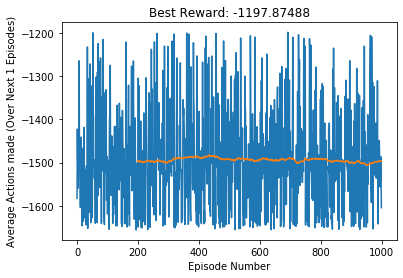

1

In [14]:
num_episodes = 1000

agent = ReinforceAgentAdvanced(env)

best_score = -np.inf

avg_scores = deque(maxlen=num_episodes)

score_eval = ScoreEvaluator(1)

for i in range(num_episodes):  
    score = 0
    state = env.reset()
    agent.reset_episode()
    
    while True:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        
        agent.step(state, reward, done)
        
        score += reward
        if done:
            score_eval.add(score)
            print_iteaction(i, score_eval)
            break
            
score_eval.plot_avg_scores()

agent.find_better

In [13]:
state = env.reset()

for i in range(2):
    state = env.reset()
    while True:
        env.render()
        agent.reset_episode()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        if done:
            break
        
env.close()